# Tri-clustering

## Introduction

This notebook illustrates how to use [Clustering Geo-data Cubes (CGC)](https://cgc.readthedocs.io) to perform a tri-clustering analysis of geospatial data. This notebook builds on an analogous tutorial that illustrates how to run co-clustering analyses using CGC (see the [web page](https://cgc-tutorial.readthedocs.io/en/latest/notebooks/coclustering.html) or the [notebook on GitHub](https://github.com/esciencecenter-digital-skills/tutorial-cgc/blob/main/notebooks/coclustering.ipynb)), we recommend to have a look at that first. 

Tri-clustering is the natural generalization of co-clustering to three dimensions. As in co-clustering, one looks for similarity patterns in a data array (in 3D, a data cube) by simultaneously clustering all its dimensions. For geospatial data, the use of tri-clustering enables the analysis of datasets that include an additional dimension on top of space and time. This extra dimension is ofter referred to as the 'band' dimension by analogy with color images, which include three data layers (red, green and blue) for each pixel. Tri-clusters in such arrays can be identified as spatial regions for which data across a subset of bands behave similarly in a subset of the times considered.  

In this notebook we illustrate how to perform a tri-clustering analysis with the CGC package using a phenological dataset that includes three products: the day of the year of first leaf appearance, first bloom, and last freeze in the conterminous United States. For more information about this dataset please check the [co-clustering tutorial](https://github.com/esciencecenter-digital-skills/tutorial-cgc/blob/main/notebooks/coclustering.ipynb) or have a look at the [original publication](https://doi.org/10.1016/j.agrformet.2018.06.028). 

Note that in addition to CGC, whose installation instructions can be found [here](https://github.com/phenology/cgc), few other packages are required in order to run this notebook. Please have a look at this tutorial's [installation instructions](https://github.com/escience-academy/tutorial-cgc). 

## Imports and general configuration

In [1]:
import cgc
import logging
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from dask.distributed import Client, LocalCluster

from cgc.triclustering import Triclustering
from cgc.kmeans import Kmeans
from cgc.utils import calculate_tricluster_averages

print(f'CGC version: {cgc.__version__}')

CGC version: 0.5.0


CGC makes use of `logging`, set the desired verbosity via:

In [2]:
logging.basicConfig(level=logging.INFO)

## Reading the data

We use [the Xarray package](http://xarray.pydata.org) to read the data. We open the Zarr archive containing the data set and convert it from a collection of three  data variables (each having dimensions: time, x and y) to a single array (a `DataArray`):

In [3]:
spring_indices = xr.open_zarr('/data/shared/Big-Geodata-Processing-2021-1A/distributed_computing_machine_learning/Data/Phenology/spring-indices.zarr', chunks=None)
print(spring_indices)

<xarray.Dataset>
Dimensions:      (time: 40, y: 155, x: 312)
Coordinates:
  * time         (time) int64 1980 1981 1982 1983 1984 ... 2016 2017 2018 2019
  * x            (x) float64 -126.2 -126.0 -125.7 -125.5 ... -56.8 -56.57 -56.35
  * y            (y) float64 49.14 48.92 48.69 48.47 ... 15.23 15.01 14.78 14.56
Data variables:
    first-bloom  (time, y, x) float64 ...
    first-leaf   (time, y, x) float64 ...
    last-freeze  (time, y, x) float64 ...
Attributes:
    crs:        +init=epsg:4326
    res:        [0.22457882102988036, -0.22457882102988042]
    transform:  [0.22457882102988036, 0.0, -126.30312894720473, 0.0, -0.22457...


(NOTE: if the dataset is not available locally, replace the path above with the following URL: https://raw.githubusercontent.com/esciencecenter-digital-skills/tutorial-cgc/main/data/spring-indices.zarr . The `aiohttp` and `requests` packages need to be installed to open remote data, which can be done via: `pip install aiohttp requests`)

In [4]:
spring_indices = spring_indices.to_array(dim='spring_index')
print(spring_indices)

<xarray.DataArray (spring_index: 3, time: 40, y: 155, x: 312)>
array([[[[117., 120., 126., ..., 184., 183., 179.],
         [ nan,  nan, 118., ..., 181., 178., 176.],
         [ nan,  nan,  nan, ..., 176., 176., 176.],
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

        [[ 92.,  96., 104., ..., 173., 173., 170.],
         [ nan,  nan,  92., ..., 171., 167., 164.],
         [ nan,  nan,  nan, ..., 165., 164., 163.],
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

        [[131., 134., 139., ..., 187., 187., 183.],
         [ nan,  nan, 133., ..., 183., 180., 178.],
         [ nan,  nan,  nan, ..., 176., 176., 176.],
         ...,
...
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  n

The spring index is now loaded as a 4D-array whose dimensions (spring index, time, y, x) are labeled with coordinates (spring-index label, year, latitude, longitude).

We can inspect the data set by plotting a slice along the time dimension:

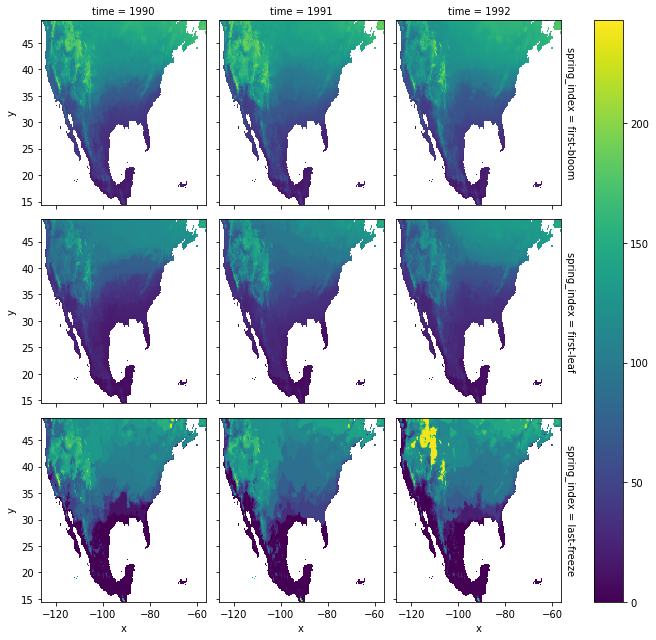

In [5]:
# select years from 1990 to 1992
spring_indices.sel(time=slice(1990, 1992)).plot.imshow(row='spring_index', col='time')

We manipulate the array spatial dimensions creating a combined (x, y) dimension. We also drop the grid cells that have null values for any spring-index and year:

In [6]:
spring_indices = spring_indices.stack(space=['x', 'y'])
location = np.arange(spring_indices.space.size) # create a combined (x,y) index
spring_indices = spring_indices.assign_coords(location=('space', location))

# drop pixels that are null-valued for any year/spring-index
spring_indices = spring_indices.dropna('space', how='any')  
print(spring_indices)

<xarray.DataArray (spring_index: 3, time: 40, space: 23584)>
array([[[117., 120., 126., ..., 173., 171., 170.],
        [ 92.,  96., 104., ..., 167., 167., 166.],
        [131., 134., 139., ..., 178., 179., 179.],
        ...,
        [118., 120., 126., ..., 179., 180., 179.],
        [112., 115., 120., ..., 185., 186., 188.],
        [114., 116., 119., ..., 175., 176., 175.]],

       [[ 60.,  63.,  73., ..., 127., 126., 125.],
        [ 35.,  38.,  45., ..., 130., 129., 127.],
        [ 59.,  63.,  74., ..., 135., 136., 136.],
        ...,
        [ 63.,  68.,  77., ..., 137., 139., 137.],
        [ 46.,  51.,  61., ..., 133., 133., 109.],
        [ 63.,  67.,  77., ..., 140., 140., 139.]],

       [[ 28.,  30.,  41., ...,  94.,  90.,  50.],
        [ 33.,  38.,  45., ..., 101.,  97.,  54.],
        [ 30.,  47.,  61., ..., 108., 104.,  57.],
        ...,
        [ 11.,  22.,  53., ..., 111., 109.,  62.],
        [ 53.,  55.,  64., ..., 114., 115., 115.],
        [ 68.,  69.,  75., ..

In [7]:
# size of the array
print("{} MB".format(spring_indices.nbytes/2**20))

21.591796875 MB


## The tri-clustering analysis

### Overview

Once we have loaded the data set as a 3D array, we can run the tri-clustering analysis. As for co-clustering, the algorithm implemented in CGC starts from a random cluster assignment and it iteratively updates the tri-clusters. When the loss function does not change by more than a given threshold in two consecutive iterations, the cluster assignment is considered converged. 

Also for tri-clustering multiple differently-initialized runs need to be performed in order to sample the cluster space, and to avoid local minima as much as possible. For more information about the algorithm, have a look at CGC's [co-clustering](https://cgc.readthedocs.io/en/latest/coclustering.html#co-clustering) and [tri-clustering](https://cgc.readthedocs.io/en/latest/triclustering.html#tri-clustering) documentation.

To run the analysis for the data set that we have loaded in the previous section, we first choose an initial number of clusters for the band, space, and time dimensions, and set the values of few other parameters:

In [8]:
num_band_clusters = 3
num_time_clusters = 5
num_space_clusters = 20

max_iterations = 50  # maximum number of iterations
conv_threshold = 0.1  # convergence threshold 
nruns = 3  # number of differently-initialized runs

**NOTE**: the number of clusters have been selected in order to keep the memory requirement and the time of the execution suitable to run this tutorial on [mybinder.org](https://mybinder.org). If the infrastructure where you are running this notebook has more memory and computing power available, feel free to increase these values.

We then instantiate a `Triclustering` object:

In [9]:
tc = Triclustering(
    spring_indices.data,  # data array with shape: (bands, rows, columns)
    num_time_clusters,  
    num_space_clusters,
    num_band_clusters, 
    max_iterations=max_iterations,  
    conv_threshold=conv_threshold, 
    nruns=nruns
)

As for co-clustering, one can now run the analysis on a local system, using a [Numpy](https://numpy.org)-based implementation, or on a distributed system, using a [Dask](https://dask.org)-based implementation. 

### Numpy-based implementation (local)

Also for tri-clustering, the `nthreads` argument sets the number of threads spawn (i.e. the number of runs that are simultaneously executed): 

In [10]:
results = tc.run_with_threads(nthreads=1)

INFO:cgc.triclustering:Waiting for run 0
INFO:cgc.triclustering:Error = -895976263.4090663
INFO:cgc.triclustering:Waiting for run 1
INFO:cgc.triclustering:Error = -896100528.6489203
INFO:cgc.triclustering:Waiting for run 2
INFO:cgc.triclustering:Error = -896006983.8937331


The output might indicate that for some of the runs convergence is not achieved within the specified number of iterations - increasing this value to ~500 should lead to converged solutions within the threshold provided.

**NOTE**: The low-memory implementation that is available for the [co-clustering algorithm](https://cgc.readthedocs.io/en/latest/coclustering.html#co-clustering) is currently not available for tri-clustering.

### Dask-based implementation (distributed systems)

As for the [co-clusterign algorithm](https://cgc.readthedocs.io/en/latest/coclustering.html#co-clustering), Dask arrays are employed in a dedicated implementation to process the data in chunks. If a compute cluster is used, data are distributed across the nodes of the cluster.

In order to load the data set as a `DataArray` using Dask arrays as underlying structure, we specify the `chunks` argument in `xr.open_zarr()`:

In [11]:
# set a chunk size of 10 along the time dimension, no chunking in x and y
chunks = {'time': 10, 'x': -1, 'y': -1 }
spring_indices_dask = xr.open_zarr('/data/shared/Big-Geodata-Processing-2021-1A/distributed_computing_machine_learning/Data/Phenology/spring-indices.zarr', chunks=chunks)
spring_indices_dask = spring_indices_dask.to_array(dim='spring-index')
print(spring_indices_dask)

<xarray.DataArray 'stack-f054bd091053ec1591534433c6663afb' (spring-index: 3, time: 40, y: 155, x: 312)>
dask.array<stack, shape=(3, 40, 155, 312), dtype=float64, chunksize=(1, 10, 155, 312), chunktype=numpy.ndarray>
Coordinates:
  * time          (time) int64 1980 1981 1982 1983 1984 ... 2016 2017 2018 2019
  * x             (x) float64 -126.2 -126.0 -125.7 ... -56.8 -56.57 -56.35
  * y             (y) float64 49.14 48.92 48.69 48.47 ... 15.01 14.78 14.56
  * spring-index  (spring-index) <U11 'first-bloom' 'first-leaf' 'last-freeze'
Attributes:
    crs:        +init=epsg:4326
    res:        [0.22457882102988036, -0.22457882102988042]
    transform:  [0.22457882102988036, 0.0, -126.30312894720473, 0.0, -0.22457...


We perform the same data manipulation as carried out in the previuos section. Note that all operations involving Dask arrays (including the data loading) are computed ["lazily"](https://tutorial.dask.org/01x_lazy.html) (i.e. they are not carried out until the very end).

In [12]:
spring_indices_dask = spring_indices_dask.stack(space=['x', 'y'])
spring_indices_dask = spring_indices_dask.dropna('space', how='any')

In [13]:
tc_dask = Triclustering(
    spring_indices_dask.data,
    num_time_clusters,
    num_space_clusters,
    num_band_clusters,
    max_iterations=max_iterations,  
    conv_threshold=conv_threshold, 
    nruns=nruns
)

For testing, we make use of a local Dask cluster, i.e. a cluster of processes and threads running on the same machine where the cluster is created:

In [14]:
cluster = LocalCluster()
print(cluster)

/usr/local/lib/python3.8/dist-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45877 instead
  warnings.warn(


LocalCluster(43bd5211, 'tcp://127.0.0.1:33067', workers=4, threads=8, memory=31.18 GiB)


Connection to the cluster takes place via the `Client` object:

In [15]:
client = Client(cluster)
print(client)

<Client: 'tcp://127.0.0.1:33067' processes=4 threads=8, memory=31.18 GiB>


To start the tri-clustering runs, we now pass the instance of the `Client` to the `run_with_dask` method (same as for co-clustering):

In [16]:
results = tc_dask.run_with_dask(client=client)

INFO:cgc.triclustering:Run 0
INFO:cgc.triclustering:Error = -896121915.784512
INFO:cgc.triclustering:Run 1
INFO:cgc.triclustering:Error = -895736900.9987645
INFO:cgc.triclustering:Run 2
INFO:cgc.triclustering:Error = -896173315.3177291


When the runs are finished, we can close the connection to the cluster:

In [17]:
client.close()

### Inspecting the results 

The tri-clustering results object includes the band-cluster assignment (`results.bnd_clusters`) in addition to cluster assignments in the two other dimensions, which are referred to as rows and columns by analogy with co-clustering:

In [18]:
print(f"Row (time) clusters: {results.row_clusters}")
print(f"Column (space) clusters: {results.col_clusters}")
print(f"Band clusters: {results.bnd_clusters}")

Row (time) clusters: [3 0 3 0 3 3 4 3 3 3 4 0 0 0 0 0 3 0 0 4 4 0 3 0 0 0 4 3 3 0 0 3 4 1 1 2 2
 4 1 1]
Column (space) clusters: [10 10 10 ...  1  1  4]
Band clusters: [2 1 0]


We first create `DataArray`'s for the spatial, temporal and band clusters: 

In [19]:
time_clusters = xr.DataArray(results.row_clusters, dims='time', 
                             coords=spring_indices.time.coords, 
                             name='time cluster')
space_clusters = xr.DataArray(results.col_clusters, dims='space', 
                              coords=spring_indices.space.coords, 
                              name='space cluster')
band_clusters = xr.DataArray(results.bnd_clusters, dims='spring_index', 
                             coords=spring_indices.spring_index.coords, 
                             name='band cluster')

We can now visualize the temporal clusters to which each year belongs, and make a histogram of the number of years in each cluster:

(array([15.,  4.,  2., 12.,  7.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

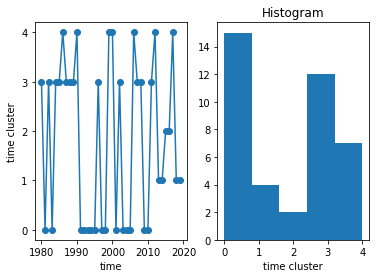

In [20]:
fig, ax = plt.subplots(1, 2)

# line plot
time_clusters.plot(ax=ax[0], x='time', marker='o')
ax[0].set_yticks(range(num_time_clusters))

# temporal cluster histogram
time_clusters.plot.hist(ax=ax[1], bins=num_time_clusters)

Similarly, we can visualize the assignment of the spring indices to the band clusters:

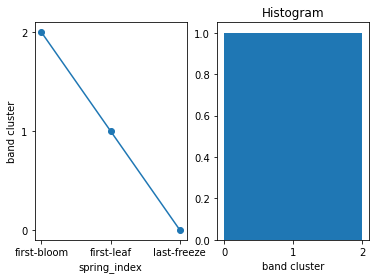

In [21]:
fig, ax = plt.subplots(1, 2)

# line plot
band_clusters.plot(ax=ax[0], x='spring_index', marker='o')
ax[0].set_yticks(range(num_band_clusters))

# band cluster histogram
band_clusters.plot.hist(ax=ax[1], bins=num_band_clusters)
ax[1].set_xticks(range(num_band_clusters))

Spatial clusters can also be visualized after 'unstacking' the location index that we have initially created, thus reverting to the original (x, y) coordinates:

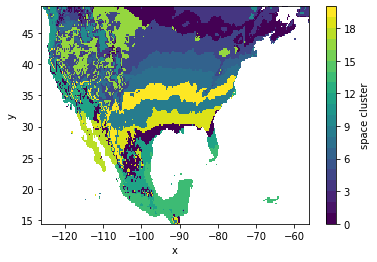

In [22]:
space_clusters_xy = space_clusters.unstack('space')
space_clusters_xy.isel().plot.imshow(
    x='x', y='y', levels=range(num_space_clusters+1)
)

The average spring index value of each tri-cluster can be computed via a dedicated utility function in CGC, which return the cluster means in a 3D-array with dimensions `(n_bnd_clusters, n_row_clusters, n_col_clusters)`. We calculate the cluster averages and create a `DataArray` for further manipulation and plotting:

In [23]:
# calculate the tri-cluster averages
means = calculate_tricluster_averages(
    spring_indices.data, 
    time_clusters, 
    space_clusters,
    band_clusters,
    num_time_clusters, 
    num_space_clusters,
    num_band_clusters
)

means = xr.DataArray(
    means,
    coords=(
        ('band_clusters', range(num_band_clusters)),
        ('time_clusters', range(num_time_clusters)), 
        ('space_clusters', range(num_space_clusters))
    )
)

The computed cluster means and the spatial clusters can be employed to plot the average spring-index value for each of the band and temporal clusters. It is important to realize that multiple spring indices might get assigned to the same band cluster, in which case the corresponding cluster-based means are computed over more than one spring index.

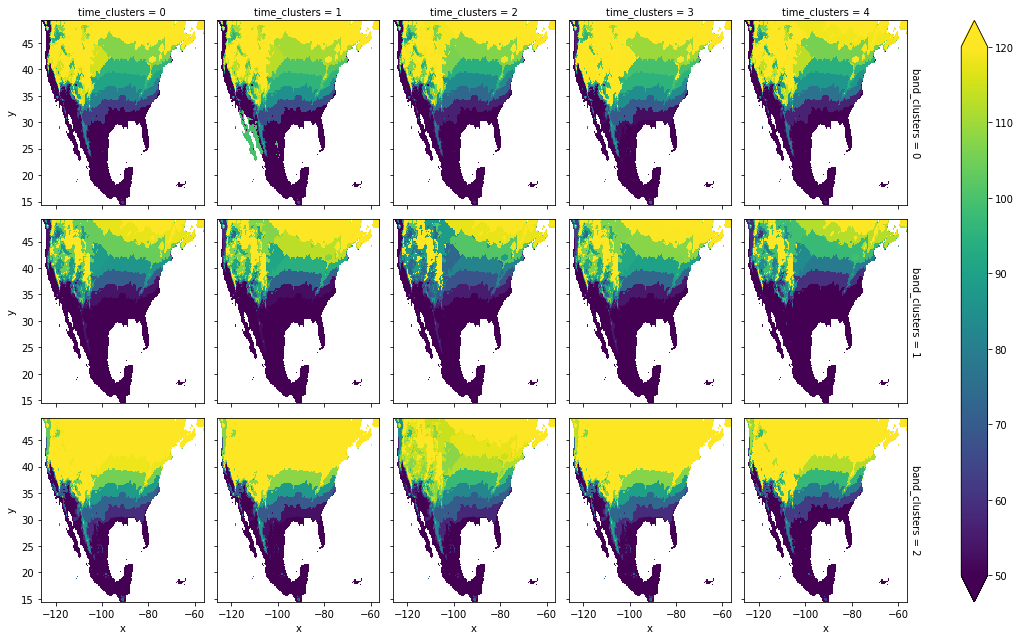

In [24]:
space_means = means.sel(space_clusters=space_clusters, drop=True)
space_means = space_means.unstack('space')
space_means.plot.imshow(
    x='x', y='y',
    row='band_clusters',
    col='time_clusters',
    vmin=50, vmax=120
)

## K-means refinement

### Overview

As co-clustering, also tri-clustering leads to a 'blocked' structure of the original data. Also here, an additional cluster-refinement analysis using [k-means](https://en.wikipedia.org/wiki/K-means_clustering) can help to identify patterns that are common across blocks (actually cubes for tri-clustering) and to merge the blocks with the highest similarity degree within the same cluster. See the [co-clustering](https://cgc-tutorial.readthedocs.io/en/latest/notebooks/coclustering.html) tutorial for more details on the selection of optimal k-value.

In [25]:
clusters = (results.bnd_clusters, results.row_clusters, results.col_clusters)
nclusters = (num_band_clusters, num_time_clusters, num_space_clusters)
km = Kmeans(
    spring_indices.data,
    clusters=clusters,
    nclusters=nclusters,
    k_range=range(2, 10)
)

The refinement analysis is then run as:

In [26]:
results_kmeans = km.compute()

### Results

The object returned by `Kmeans.compute` contains all results, most importantly the optimal `k` value:

In [27]:
print(f"Optimal k value: {results_kmeans.k_value}")

Optimal k value: 2


The centroids of the tri-cluster means can be employed to plot the refined cluster averages of the spring index dataset. Note that the refined clusters merge tri-clusters across all dimensions, including the band axis. Thus, the means of these refined clusters correspond to averages over more than one spring index.

In [28]:
means_kmeans = xr.DataArray(
    results_kmeans.cl_mean_centroids, 
    coords=(
        ('band_clusters', range(num_band_clusters)),
        ('time_clusters', range(num_time_clusters)), 
        ('space_clusters', range(num_space_clusters))
    )
)

# drop tri-clusters that are not populated  
means_kmeans = means_kmeans.dropna('band_clusters', how='all')
means_kmeans = means_kmeans.dropna('time_clusters', how='all')
means_kmeans = means_kmeans.dropna('space_clusters', how='all')

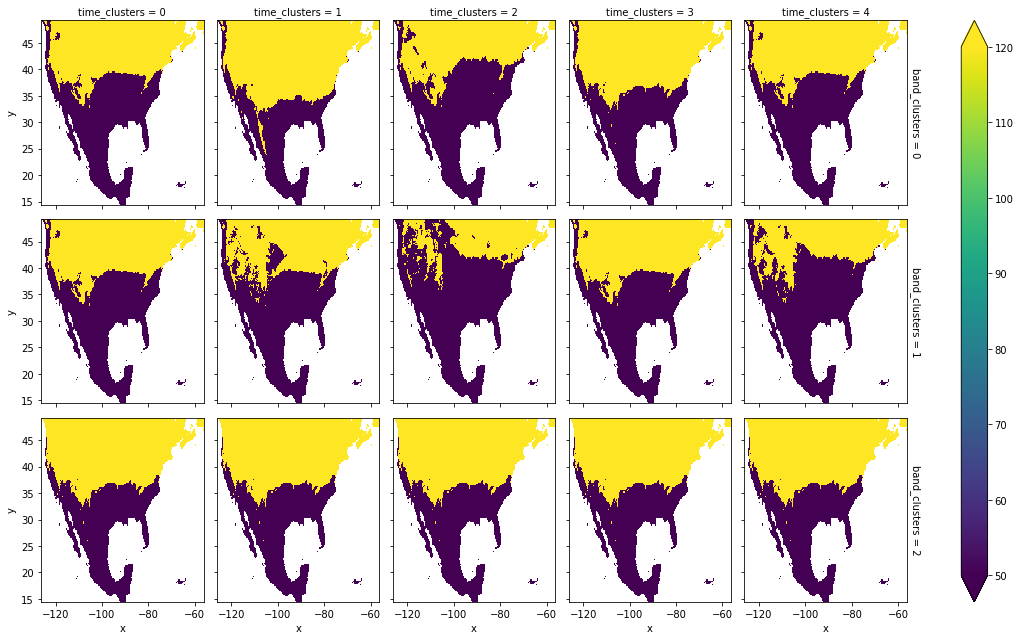

In [29]:
space_means = means_kmeans.sel(space_clusters=space_clusters, drop=True)
space_means = space_means.unstack('space')
space_means.squeeze().plot.imshow(
    x='x', y='y', 
    row='band_clusters',
    col='time_clusters',
    vmin=50, vmax=120
)